<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Paddy/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction using LSTM
This project aims to predict stock prices using historical data and Long Short-Term Memory (LSTM) neural networks.

## Data Loading and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset (had to make a shortcut from "Shared with Me" to MyDrive)
sp500=pd.read_csv('/content/drive/MyDrive/cs3244_data/ETFs/spy.us.txt')
sp500.drop(columns={'OpenInt','Volume'}, inplace=True)
# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

In [4]:
# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]


In [5]:
# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

# Replace the original sp500 DataFrame with the modified one
sp500 = new_sp500
sp500

<ipython-input-5-90077ebfbdb0>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)


,Date,Price,Type of Price
0,2005-02-25,104.770,open
1,2005-02-25,105.340,average
2,2005-02-25,105.790,close
3,2005-02-28,105.550,open
4,2005-02-28,105.120,average
...,...,...,...
9598,2017-11-09,257.375,average
9599,2017-11-09,258.170,close
9600,2017-11-10,257.730,open
9601,2017-11-10,257.790,average


## Neural Network Architecture

In [ ]:
print(sp500) # test case

# Preparing data for LSTM (Use 'Close' prices for simplicity)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.set_index('Date', inplace=True)

            Date    Price Type of Price
0     2005-02-25  104.770          open
1     2005-02-25  105.340       average
2     2005-02-25  105.790         close
3     2005-02-28  105.550          open
4     2005-02-28  105.120       average
...          ...      ...           ...
9598  2017-11-09  257.375       average
9599  2017-11-09  258.170         close
9600  2017-11-10  257.730          open
9601  2017-11-10  257.790       average
9602  2017-11-10  258.090         close

[9603 rows x 3 columns]


In [ ]:
# Use only 'Close' prices for prediction
data = sp500[sp500['Type of Price'] == 'close']['Price'].values
data = data.reshape(-1, 1)

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Define lookback period (e.g., use the past 60 days of data to predict the next day)
lookback = 60
X_train = []
y_train = []


for i in range(lookback, len(scaled_data)):
    X_train.append(scaled_data[i-lookback:i, 0])
    y_train.append(scaled_data[i, 0])

In [ ]:
# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshape data to be [samples, time steps, features] for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Define the LSTM Model
model = Sequential()

In [ ]:
# LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Fully connected layer
model.add(Dense(units=1))  # Output layer for predicting the next price

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()  # To see the architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Training the Model Using Prepared Dataset

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X_train) * 0.8)
X_test = X_train[train_size:]
y_test = y_train[train_size:]
X_train = X_train[:train_size]
y_train = y_train[:train_size]

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.0254
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.8048e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 1.8353e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - loss: 1.8137e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 1.7627e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 1.6742e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 1.6206e-04
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 1.6502e-04
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.4548e-04
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.4945e-04


In [ ]:
# Predicting on the test data
predicted_stock_price = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [ ]:
# Invert scaling to get actual stock prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

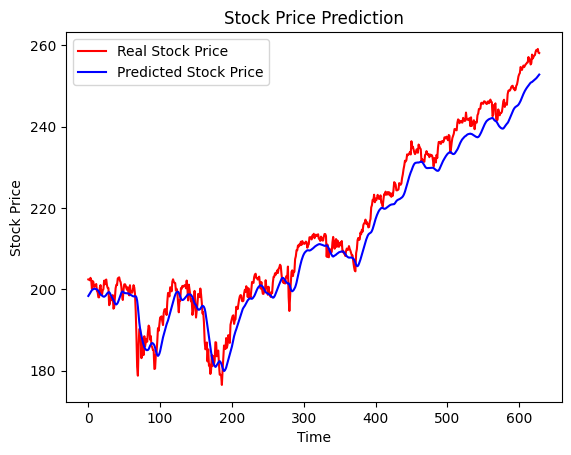

In [ ]:
# Evaluate the model performance by plotting the results
import matplotlib.pyplot as plt

plt.plot(y_test, color='red', label='Real Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Key Points:
- We split the dataset into **80% training** and **20% testing**.
- The model is trained using **10 epochs** and a **batch size of 32**. You can increase these numbers to improve the model’s learning but it may take longer.
- After training, the model’s predictions are plotted against the real stock prices for comparison.

### Notes:
- **Normalization**: We normalize the stock prices to the range of 0 to 1 using `MinMaxScaler` before training the model, as LSTM networks generally perform better with normalized data.
- **Lookback Window**: In this case, we use a lookback period of 60 days to predict the next day’s price. You can adjust the lookback window to tune performance.



Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 1.5066e-04 - val_loss: 1.5702e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 1.4647e-04 - val_loss: 1.5821e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 1.4357e-04 - val_loss: 1.4536e-04
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.2344e-04 - val_loss: 2.0374e-04
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 1.3698e-04 - val_loss: 1.4232e-04
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 1.3650e-04 - val_loss: 2.0616e-04
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 1.1703e-04 - val_loss: 1.7700e-04
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 1.4345e-04 - val_loss: 1.4945e-04
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 1.4223e-04 - val_loss: 1.4679e-04
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.2566e-04 - val_loss: 1.9244e-04


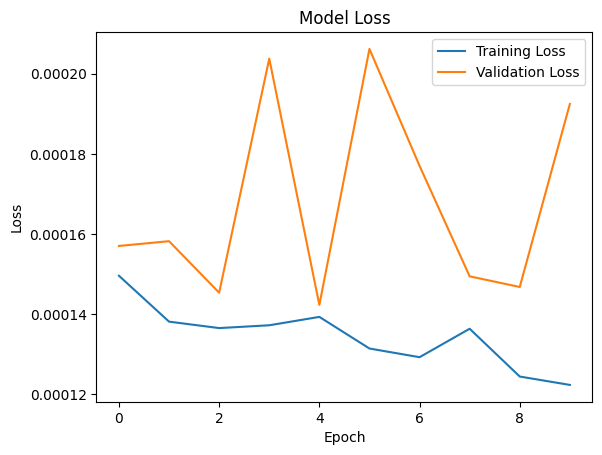

In [ ]:
# Train the model with validation split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Stock Price Prediction using SVM / SVR

In this section I am using SVR (support vector regression) to tackle this task, SVR is an extension of SVM that is used for predicting numerical values.


## import the libraries for SVR

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split

## Prepping The Data
Using the open, closing and average prices as features and predicting the closing price of the next day

In [ ]:
# Prepare the data
sp500_pivot = sp500.pivot(index='Date', columns='Type of Price', values='Price')
print(sp500_pivot)

# features
x = sp500_pivot[['open', 'average', 'close']].values
# target
y = sp500_pivot['close'].shift(-1).dropna().values


# using closing price to predict next day's opening price
# # features
# x = sp500_pivot[['close']].values
# # target
# y = sp500_pivot['open'].shift(-1).dropna().values


x = x[:-1]  # Align feature the target
print("feature:", x)
print()
print("target", y)

Type of Price  average   close    open
Date                                  
2005-02-25     105.340  105.79  104.77
2005-02-28     105.120  105.08  105.55
2005-03-01     105.545  105.62  105.22
2005-03-02     105.660  105.57  105.21
2005-03-03     105.675  105.61  105.99
...                ...     ...     ...
2017-11-06     258.610  258.85  258.30
2017-11-07     258.730  258.67  258.97
2017-11-08     258.685  259.11  258.47
2017-11-09     257.375  258.17  257.73
2017-11-10     257.790  258.09  257.73

[3201 rows x 3 columns]
feature: [[104.77  105.34  105.79 ]
 [105.55  105.12  105.08 ]
 [105.22  105.545 105.62 ]
 ...
 [258.97  258.73  258.67 ]
 [258.47  258.685 259.11 ]
 [257.73  257.375 258.17 ]]

target [105.08 105.62 105.57 ... 259.11 258.17 258.09]


## Normalise the targat and features

In [20]:
# Normalise the 'close' prices only using a separate scaler
scaler_close = MinMaxScaler()
 # Fit scaler only on the 'close' column
 # rescales the target to a range between 0 and 1
y_scaled = scaler_close.fit_transform(y.reshape(-1, 1))

# Normalise the features ('open', 'average', 'close')
# features are also normalized to the range [0, 1]
scaler_features = MinMaxScaler()
x_scaled = scaler_features.fit_transform(x)

# Split the data into training (80%) + testing(20%)
# training: 2005-02 -- 2015-05
# testing: 2015-05 -- 2017-11
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, shuffle=False)



## Function to create sequence of past data points

In [16]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


## Final set up for data to be inputted as parameters

In [21]:
# Set the time step (number of previous days to look at)
TIME_STEPS = 60

# Create sequences of past data points for training and testing
X_train, y_train = create_dataset(x_train, y_train, TIME_STEPS)
X_test, y_test = create_dataset(x_test, y_test, TIME_STEPS)

# flatten the sequence for SVR
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')



X_train shape: (2500, 60, 3)
y_train shape: (2500, 1)


## Hyperparameter Tuning + Stats for the model

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
from sklearn.exceptions import DataConversionWarning
import numpy as np

# Suppress the DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

x_grid_search_sample = X_train_flat[:2000]
y_grid_search_sample = y_train[:2000]

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
    'epsilon': [0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear']
}

svr = SVR()

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_grid_search_sample, y_grid_search_sample)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Initialise the model
svr = grid_search.best_estimator_

# Train the model
svr.fit(X_train_flat, y_train.ravel())

# Make predictions on the training and test data
train_predictions = svr.predict(X_train_flat)
test_predictions = svr.predict(X_test_flat)

# Inverse transform the predicted values for 'close' prices back to the original scale
train_predictions_original = scaler_close.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions_original = scaler_close.inverse_transform(test_predictions.reshape(-1, 1))

# Inverse transform the actual target values ('close') for comparison
y_train_original = scaler_close.inverse_transform(y_train)
y_test_original = scaler_close.inverse_transform(y_test)

# Calculate the Training and Validation (Test) Loss (MSE)
train_loss = mean_squared_error(y_train_original, train_predictions_original)
test_loss = mean_squared_error(y_test_original, test_predictions_original)

# Calculate MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_train_original, train_predictions_original)
mae_test = mean_absolute_error(y_test_original, test_predictions_original)

# Calculate R² (Coefficient of Determination)
r2_train = r2_score(y_train_original, train_predictions_original)
r2_test = r2_score(y_test_original, test_predictions_original)

# Calculate RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(train_loss)
rmse_test = np.sqrt(test_loss)

# Calculate bias (mean difference between real and predicted values)
bias_train = np.mean(y_train_original - train_predictions_original)
bias_test = np.mean(y_test_original - test_predictions_original)

# Apply bias correction to the test predictions
test_predictions_corrected = test_predictions_original + bias_test

# Output the results
print(f'Training Loss (MSE): {train_loss}')
print(f'Validation Loss (MSE): {test_loss}')
print(f'Bias in Training Set: {bias_train}')
print(f'Bias in Validation Set: {bias_test}')
print(f'Training MAE: {mae_train}')
print(f'Validation MAE: {mae_test}')
print(f'Training R²: {r2_train}')
print(f'Validation R²: {r2_test}')
print(f'Training RMSE: {rmse_train}')
print(f'Validation RMSE: {rmse_test}')


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ......C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf; total time=   0.4s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf; total time=   0.4s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf; total time=   0.4s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf; total time=   0.4s
[CV] END ......C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf; total time=   0.4s
[CV] END ...C=0.1, epsilon=0.01, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...C=0.1, epsilon=0.01, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...C=0.1, epsilon=0.01, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...C=0.1, epsilon=0.01, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...C=0.1, epsilon=0.01, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END .......C=0.1, epsilon=0.01, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END .......C=0.1, epsilon=0.01, gamma=0.00

plot the predictions vs the actual values

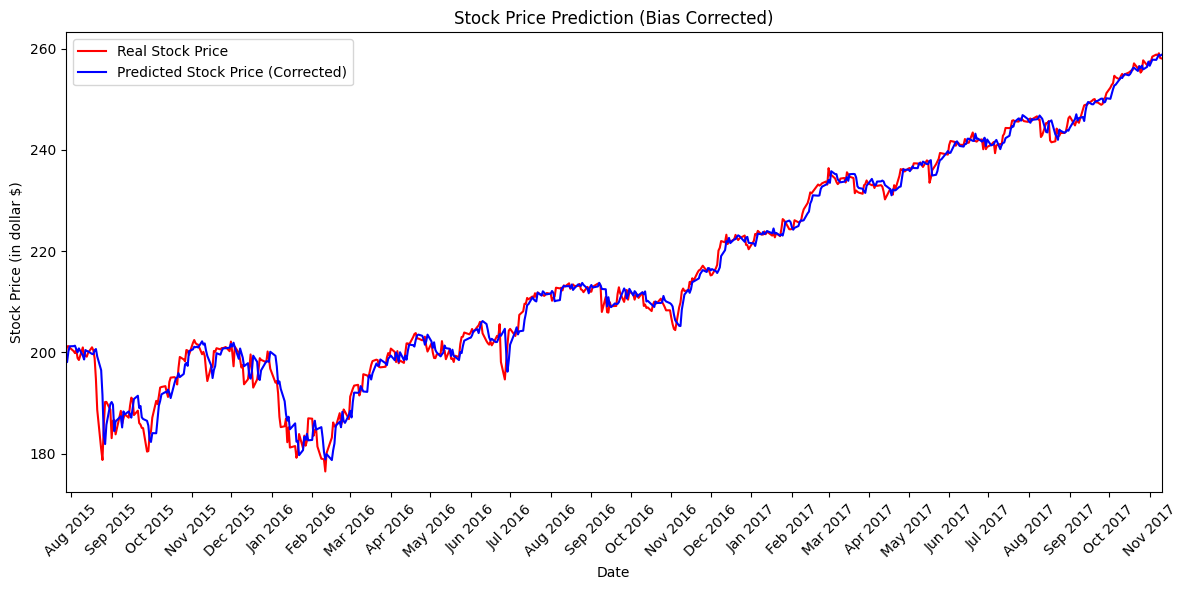

In [23]:
# Plot the actual vs corrected predicted stock prices (in original scale)
plt.figure(figsize=(12, 6))  # Set the figure size

# Use the last len(y_test_original) dates from the dataset for the test set
test_set_dates = sp500_pivot.index[-len(y_test_original):]
test_set_dates = pd.to_datetime(test_set_dates)  # Ensure it's in datetime format

plt.plot(test_set_dates, y_test_original, color='red', label='Real Stock Price')  # Plot real stock prices
plt.plot(test_set_dates, test_predictions_corrected, color='blue', label='Predicted Stock Price (Corrected)')  # Plot corrected predicted stock prices

plt.title('Stock Price Prediction (Bias Corrected)')
plt.xlabel('Date')
plt.ylabel('Stock Price (in dollar $)')

# Set x-axis limits and format
plt.xlim([test_set_dates[0], test_set_dates[-1]])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format to show month and year
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.legend()
plt.tight_layout()
plt.show()


SVR is an extension of SVM that is used for predicting numerical values

- kernel=’linear’ specifies the kernel function to be used. 
- gamma=0.0001 is the parameter for the linear kernel. It controls the influence of each training example. A low value means ‘far’ and a high value means ‘close’ relative to the hyperplane.
- C=1 is the regularization parameter. It trades off correct classification of training examples against maximization of the decision function’s margin.
- epsilon=0.01 is the epsilon parameter in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function.

the best TIME_STEPS (days to look back at is around 60, 2 month)

https://www.geeksforgeeks.org/time-series-forecasting-with-support-vector-regression/

## Performance of the model

- Training MSE: 3.20, this suggests the model is fitting the training data well, on average the squared difference between the predication price and actual price is 3.20.
- Validation MSE: 5.14, higher than the training loss (expected) this means for unseen data, the prediction price differs 5.14 from the actual price.
- Training MAE: 1.34
- Validation MAE: 1.58
- Training RMSE: 1.79
- Validation RMSE: 2.27

## Room for improvement
- more data
- grid search with a larger sample size (take really long to find the best parameter)